<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/eval/EMB_SM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [3]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [4]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]

In [ ]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
328982,very disappointed very the description was mis...,0
159078,great movie so so dvd the digital transfer is ...,1
121852,no rocksteady here i would have given this NUM...,0
308298,good while it lasted the pen was great the onl...,1
131223,taking it back i bought this on saturday from ...,0


In [ ]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
5914,thanks for the fast efficient service a number...,1
13524,so its a cd full of savestates save states or ...,0
12243,second rate this recording is pretty and that ...,0
19456,a good dvd well i would be more happier with t...,1
13886,does not work the tasty was not good and was s...,0


In [ ]:
train, val = split_data(data)

In [ ]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [ ]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [ ]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [ ]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])

## Embedding

In [5]:
def build_emb(hp):
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(
        Embedding(
          num_words, hp.get('output_dim')
        )
    )
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=get_optimizer(hp.get('optimizer')),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [6]:
hp = HyperParameters()
hp.Int('output_dim', 16, 64, 16)
hp.Choice('optimizer', optimizers)

'Adam'

In [7]:
tuner = get_tuner(build_emb,'/content/drive/MyDrive/sentiment/EMB',\
                  'EMB_SM_B32',hp, 2, 2)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/sentiment/EMB/EMB_SM_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 8002      
Total params: 168,002
Trainable params: 168,002
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/sentiment/EMB/EMB_SM_B32/tuner0.json


## Train

In [ ]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=1,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 2 Complete [00h 07m 19s]
val_loss: 0.25727030634880066

Best val_loss So Far: 0.25727030634880066
Total elapsed time: 00h 15m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 32002     
Total params: 672,002
Trainable params: 672,002
Non-trainable params: 0
_________________________________________________________________


## Refit

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16002     
Total params: 336,002
Trainable params: 336,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model = get_model_from_config(
    best_model,
    tuner.get_best_hyperparameters()[0].get('optimizer')
)

In [ ]:
cb = get_callbacks('emb_sm.h5')

In [ ]:
history = best_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs=100,
    callbacks=cb
)

Epoch 1/100
9563/9563 [==============================] - 109s 11ms/step - loss: 0.3304 - accuracy: 0.8523 - precision: 0.8941 - recall: 0.8941 - true_positives: 173387.1894 - true_negatives: 173387.1894 - false_positives: 20836.8014 - false_negatives: 20836.8014 - val_loss: 0.2571 - val_accuracy: 0.8985 - val_precision: 0.8985 - val_recall: 0.8985 - val_true_positives: 48516.0000 - val_true_negatives: 48516.0000 - val_false_positives: 5482.0000 - val_false_negatives: 5482.0000

Epoch 00001: val_loss improved from inf to 0.25707, saving model to emb_sm2.h5
Epoch 2/100
9563/9563 [==============================] - 109s 11ms/step - loss: 0.2086 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - true_positives: 140524.4423 - true_negatives: 140524.4423 - false_positives: 12515.5485 - false_negatives: 12515.5485 - val_loss: 0.2735 - val_accuracy: 0.8941 - val_precision: 0.8941 - val_recall: 0.8941 - val_true_positives: 48282.0000 - val_true_negatives: 48282.0000 - val_false_positives:

0.25345414876937866


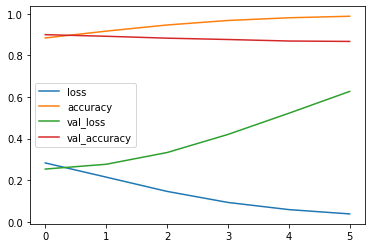

In [ ]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
# print(min(history.history['val_loss']))
pd.DataFrame(history.history)[metr].plot()

In [ ]:
# dump(history.history, 'history.pickle')

In [ ]:
# dump(tokenizer, 'tokenizer.pickle')

## Test

In [ ]:
sequence_test = get_sequences(tokenizer, max_len, test['text'])
test_target = OH_transform(test['target'])

 89/625 [===>..........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 1s 2ms/step
Accuracy:	89.9%


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10000
           1       0.90      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



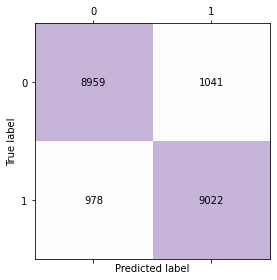

In [ ]:
model_evaluate(best_model, sequence_test, test_target, 32)

## Insights

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [9]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/EMB/EMB_SM_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
output_dim: 32
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.25727030634880066
Trial summary
Hyperparameters:
output_dim: 48
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.2609699219465256
